In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from IPython.display import Markdown
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [2]:
N_SEED = 19
TOP_K = 5
VERBOSE = 1
N_JOBS = 4
COLOR_MAP = "RdYlBu"

np.random.seed(N_SEED)

In [3]:
dataset = pd.read_csv("../data/Churn_Modelling.csv")

## EDA

In [4]:
dataset.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [6]:
dataset_transformed = dataset.drop(columns=["RowNumber", "CustomerId", "Surname"], axis=1)

In [7]:
geography_col = LabelEncoder().fit_transform(dataset["Geography"])
gender_col = LabelEncoder().fit_transform(dataset["Gender"])
y_dataset = dataset["Exited"]

In [8]:
dataset_transformed.drop(columns=["Geography", "Gender", "Exited"], axis=1, inplace=True)

In [9]:
dataset_transformed["Geography"] = pd.Series(geography_col)
dataset_transformed["Gender"] = pd.Series(gender_col)
dataset_transformed["Exited"] = pd.Series(y_dataset)

In [10]:
L_FONT = {
    "color": "darkblue",
    "size": 11
}

T_COLOR = "darkred"


def show_corr(features, target):
    features.corrwith(target).plot.bar(color="purple", grid=True)
    ax = plt.gca()
    ax.spines["bottom"].set_color(T_COLOR)
    ax.spines["top"].set_color(T_COLOR)
    ax.spines["left"].set_color(T_COLOR)
    ax.spines["right"].set_color(T_COLOR)
    ax.tick_params(axis="x", colors=T_COLOR)
    ax.tick_params(axis="y", colors=T_COLOR)
    plt.show();


def plot_features(x, target):
    _, col = x.shape
    for i in range(col):
        plt.hist(x[:, i], color="green")
        plt.xlabel("X: {i}".format(i=i), fontdict=L_FONT)
        plt.ylabel("Population", fontdict=L_FONT)
        ax = plt.gca()
        ax.spines["bottom"].set_color(T_COLOR)
        ax.spines["top"].set_color(None)
        ax.spines["left"].set_color(T_COLOR)
        ax.spines["right"].set_color(None)
        ax.tick_params(axis="x", colors=T_COLOR)
        ax.tick_params(axis="y", colors=T_COLOR)
        plt.show();


def plot_class_dist(target):
    unique, counts = np.unique(target, return_counts=True)
    plt.bar(unique, counts, color="darkblue",)
    plt.xlabel("Class", fontdict=L_FONT)
    plt.ylabel("Population", fontdict=L_FONT)
    ax = plt.gca()
    ax.set_xticks(ticks=unique, labels=unique)
    ax.spines["bottom"].set_color(T_COLOR)
    ax.spines["top"].set_color(None)
    ax.spines["left"].set_color(T_COLOR)
    ax.spines["right"].set_color(None)
    ax.tick_params(axis="x", colors=T_COLOR)
    ax.tick_params(axis="y", colors=T_COLOR)
    plt.show();


def plot_roc(fpr, tpr, roc_auc):
    plt.plot(fpr, tpr, color="darkblue", label="AUC = %0.4f" % roc_auc,)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel("TPR", fontdict=L_FONT)
    plt.xlabel("FPR", fontdict=L_FONT)
    ax = plt.gca()
    ax.set_title("Receiver Operating Characteristic", fontdict={"color": "darkblue"})
    ax.spines["bottom"].set_color(T_COLOR)
    ax.spines["top"].set_color(None)
    ax.spines["left"].set_color(T_COLOR)
    ax.spines["right"].set_color(None)
    ax.tick_params(axis="x", colors=T_COLOR)
    ax.tick_params(axis="y", colors=T_COLOR)
    plt.show();


def plot_classification(y_true, y_pred):
    precision, recall, f1, support = metrics.precision_recall_fscore_support(y_true, y_pred)
    sns.heatmap(
        (precision*100, recall*100, f1*100),
        annot=True, cmap=COLOR_MAP,
        fmt=".4f",
        yticklabels=("precision", "recall", "f1")
    )
    ax = plt.gca()
    ax.set_title("Classification Report", fontdict=L_FONT)
    ax.tick_params(axis="x", colors=T_COLOR)
    ax.tick_params(axis="y", colors=T_COLOR)
    plt.show();

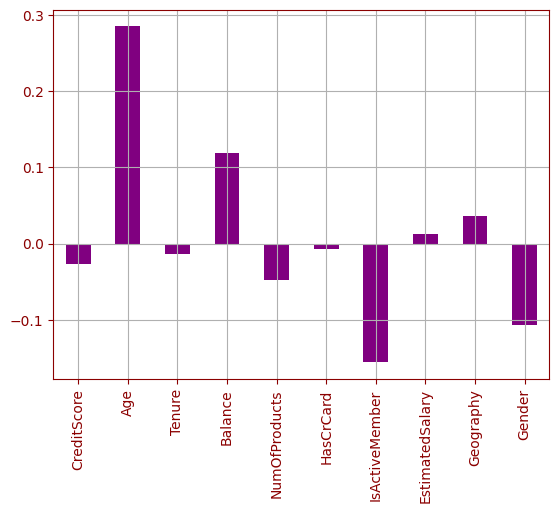

In [11]:
X_dataset = dataset_transformed.drop(columns=["Exited"], axis=1)
show_corr(X_dataset, y_dataset)

In [12]:
X = np.array(X_dataset)
y = np.array(y_dataset).reshape(-1, 1)

In [13]:
# Scale data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [14]:
_, counts = np.unique(y, return_counts=True)
class_ratio = counts[0]/counts[1]
class_ratio

np.float64(3.9091801669121256)

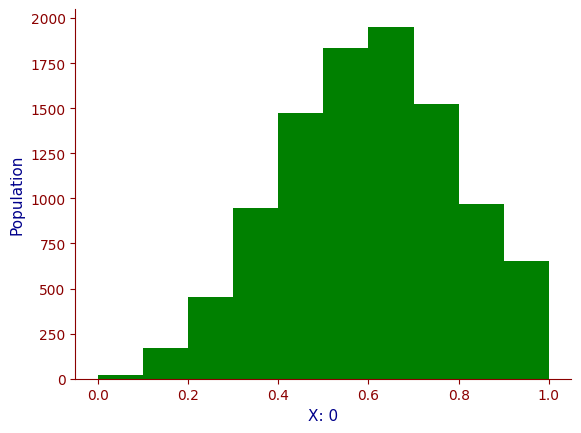

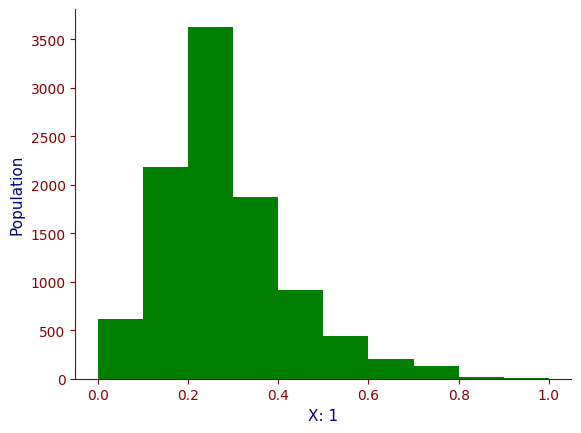

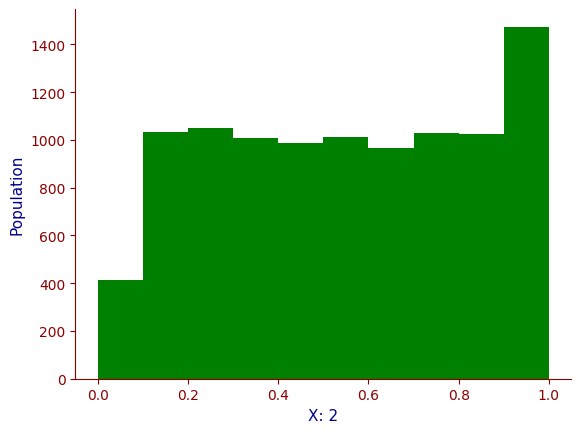

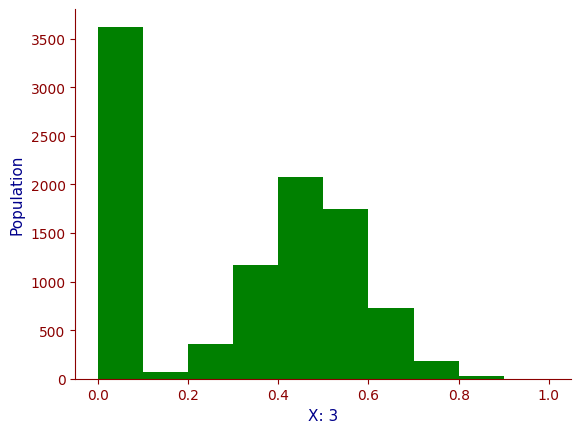

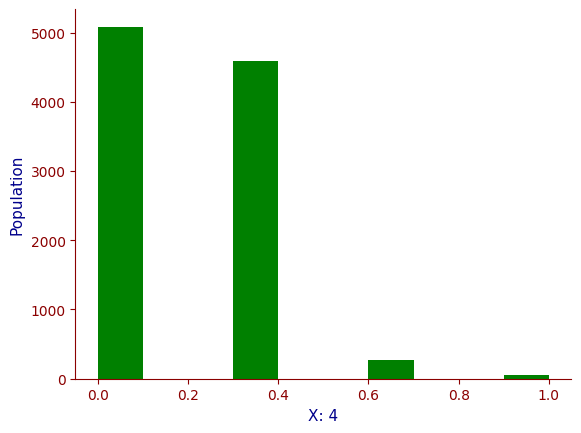

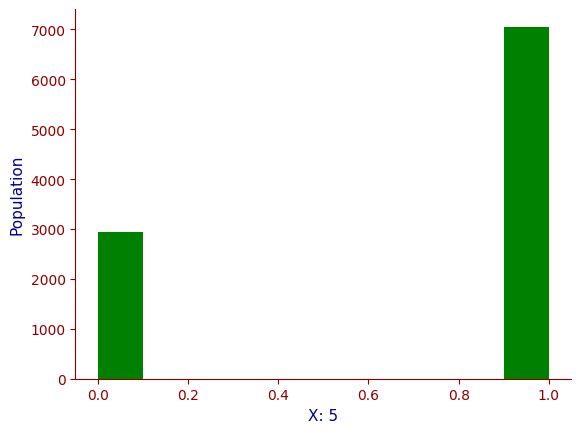

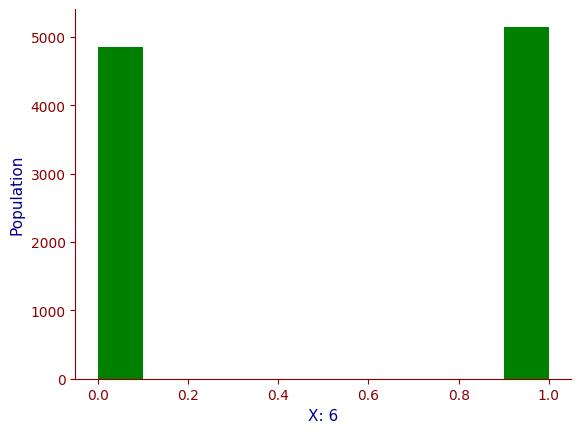

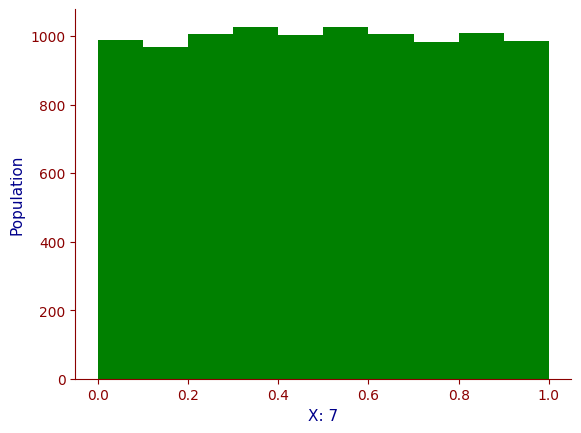

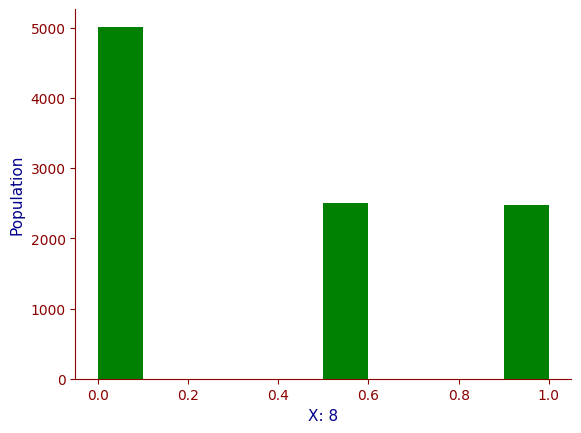

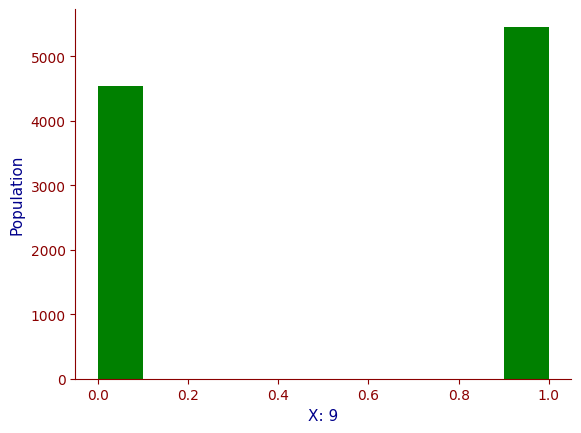

In [15]:
plot_features(X, y)

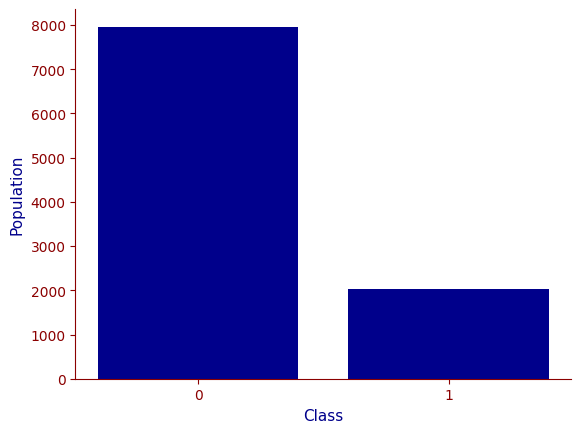

In [16]:
plot_class_dist(y)

In [17]:
X0_train, X_test, y0_train, y_test = train_test_split(X, y, test_size=0.2, random_state=N_SEED)

## Over Sampling train dataset

In [18]:
smote = SMOTE(
    sampling_strategy="minority",
    k_neighbors=5,
    random_state=N_SEED,
)

X_train, y_train = smote.fit_resample(X0_train, y0_train)
# X_train, y_train = X0_train, y0_train

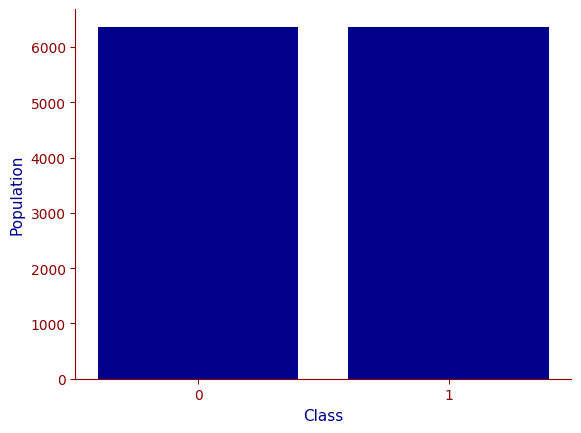

In [19]:
plot_class_dist(y_train)

## ANN

In [20]:
BATCH_SIZE = 30
NO_EPOCHS = 200

_, input_size = X.shape
HIDDEN_SIZE = 128
_, output_size = y.shape

In [21]:
layers_ANN = [
    tf.keras.layers.Input(shape=(input_size,)),
    tf.keras.layers.Dense(
        units=HIDDEN_SIZE,
        activation="relu",
    ),
    tf.keras.layers.Dense(
        units=output_size,
        activation="sigmoid"
    ),
]

model_ANN = tf.keras.models.Sequential(layers_ANN)

In [22]:
optimizer_ANN = tf.optimizers.SGD(
        learning_rate=0.01,
        nesterov=True
)

model_ANN.compile(
    optimizer=optimizer_ANN,
    loss=tf.keras.losses.BinaryCrossentropy,
    metrics=["accuracy"],
)

model_ANN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,537 (6.00 KB)

 Trainable params: 1,537 (6.00 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model_ANN.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=NO_EPOCHS, verbose=VERBOSE,)

Epoch 1/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step - accuracy: 0.5241 - loss: 0.6939
Epoch 2/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step - accuracy: 0.6228 - loss: 0.6648
Epoch 3/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step - accuracy: 0.6204 - loss: 0.6521
Epoch 4/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step - accuracy: 0.6332 - loss: 0.6408
Epoch 5/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step - accuracy: 0.6472 - loss: 0.6301
Epoch 6/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step - accuracy: 0.6560 - loss: 0.6228
Epoch 7/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step - accuracy: 0.6554 - loss: 0.6193
Epoch 8/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step - accuracy: 0.6587 - loss: 0.6151
Epoch 9/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step - accuracy: 0.6654 - loss: 0.6109
Epoch 10/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step - accuracy: 0.6751 - loss: 0.6032
Epoch 11/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step - accuracy: 0.6769 - loss: 0.6008
Epoch 12/200
425/42

In [24]:
loss_ANN, accuracy_ANN = model_ANN.evaluate(X_test, y_test)
loss_ANN, accuracy_ANN

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step - accuracy: 0.7716 - loss: 0.4535


(0.46956872940063477, 0.7615000009536743)

In [25]:
y_proba_ANN = model_ANN.predict(X_test)
y_pred_ANN = y_proba_ANN.round() 

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step


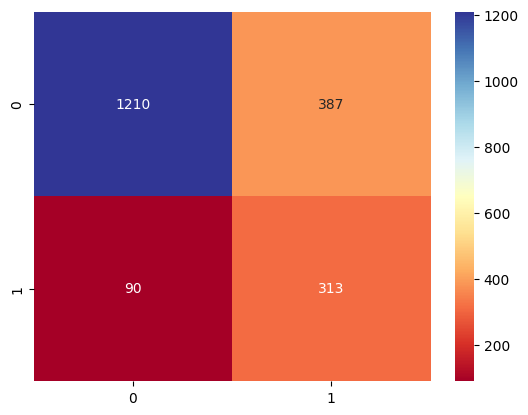

In [26]:
cm_ANN = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_ANN)
sns.heatmap(cm_ANN, annot=True, cmap=COLOR_MAP, fmt=".0f");

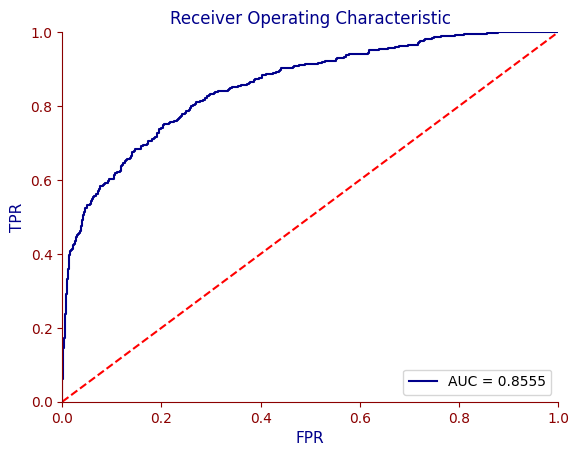

In [27]:
fpr_ANN, tpr_ANN, _ = metrics.roc_curve(y_test, y_proba_ANN)
roc_auc_ANN = metrics.auc(fpr_ANN, tpr_ANN)
plot_roc(fpr_ANN, tpr_ANN, roc_auc_ANN)

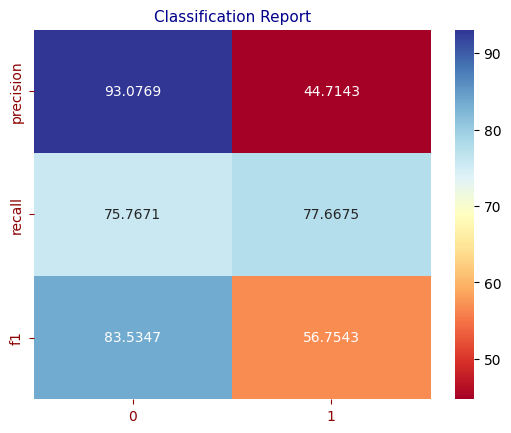

In [28]:
plot_classification(y_true=y_test, y_pred=y_pred_ANN)